Dorrit0, dorrit1, jelle0, night0, night1

In [1]:
data_path_old = r"C:\Users\Fin Amin\Desktop/\StemCellResearch\datasets_Sahil_preprocessed_final-20220525T021621Z-001\datasets_Sahil_preprocessed_final\exp1"
matrix_path = "regulator-gene-matrix.csv"
data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"
data_path_petal = r"C:\Users\Fin Amin\Desktop\StemCellResearch\petal_len.xlsx"

In [2]:

#data_path_og_exp1 = data_path_testSet 

In [3]:
import tensorflow as tf
#from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import*
import shap

# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
tf.executing_eagerly()

True

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Load the test set and the synthetic dataset:


In [6]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [7]:
test = loadTestSet(data_path_testSet)


In [8]:
def read_files(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [9]:
genes_intensities_normalized, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = genes_intensities_normalized

In [10]:
matrix.shape

(245, 245)

In [11]:
replicates.shape

(6, 6, 245)

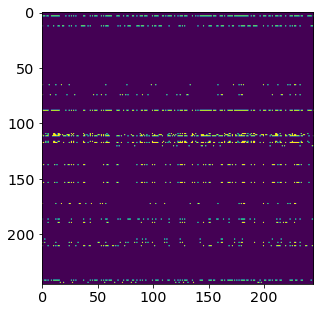

In [12]:
plt.imshow(matrix)

In [13]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
class EncoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [15]:
class DecoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        v = tf.zeros_like(X)
        u = tf.ones_like(X)
        u = tf.math.scalar_mul(-1.0, u)
        
        return tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [16]:
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [17]:
regulator_gene_matrix = matrix# np.random.randint(0, 2, size=(245, 245)).astype(np.float32)


In [18]:
enc_dec_Synthetic = model(regulator_gene_matrix, 245, 6, 245) #we can just change the time steps to something higher

In [19]:
enc_dec_Synthetic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 245)]          0         
                                                                 
 encoder_linear (EncoderLine  (None, 6, 245)           60025     
 ar)                                                             
                                                                 
 conv1d (Conv1D)             (None, 4, 32)             23552     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 21)                2709      
                                                                 
 dense_1 (Dense)             (None, 128)               2816      
                                                             

In [20]:
type(enc_dec_Synthetic)

keras.engine.functional.Functional

# Super Parent Matrix + Custom Loss
FOR USE LATER!!

In [21]:
from tensorflow.keras import losses

In [22]:
superParent = regulator_gene_matrix.copy() #init the super parent with the ordinary RGM, and do forward passes with super parent
#print(superParent.shape)

ones = np.ones((245))
parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)

def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2)
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [23]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [24]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [25]:
syntheticDataTrain = genes_intensities_normalized[1:]

In [26]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 1.3627
Epoch 2/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.2838
Epoch 3/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.1954
Epoch 4/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.1570
Epoch 5/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0653
Epoch 6/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0203
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9975
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9467
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9194
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8880
Epoch 11/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8380
Epoch 12/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.8190
Epoch 13/1000
1/1 [==============================]

In [27]:
w = enc_dec_Synthetic.get_weights()

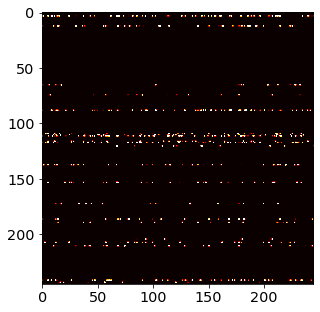

In [28]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [29]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [30]:
testCandidate = test.astype(np.float)

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [31]:
testCandidate.dtype

dtype('float64')

In [32]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [33]:
testCandidate[0].shape

(6, 245)

In [34]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [35]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

1/1 [==============================] - 0s 257ms/step


In [36]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [37]:
syntheticLoss = ignore_noParent_MSE(outSyn, testCandidate)
syntheticLoss

<tf.Tensor: shape=(), dtype=float64, numpy=1.1470786197111507>

In [38]:
(outSyn-testCandidate).shape

(4, 6, 245)

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [39]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [40]:
interpolated_genes, _ = read_filesV2(data_path_inter)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [41]:
interpolated_genes.shape

(5,)

In [42]:
pd.DataFrame(interpolated_genes[2]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.254943,-1.000000,0.663585,0.440312,-1.000000,0.635664,0.734571,-1.000000,0.312044,0.602692,...,-1.000000,0.400712,-1.000000,0.523033,-1.000000,0.561590,0.403879,0.642049,-1.000000,0.443478
1,0.338509,-1.000000,0.612395,0.655007,-1.000000,-1.000000,0.590564,-1.000000,0.353872,0.539972,...,-1.000000,0.445519,-1.000000,0.586067,-1.000000,0.541903,0.426403,0.495559,0.550973,0.419991
2,-1.000000,0.544463,0.596307,0.596367,-1.000000,0.629406,0.579586,0.726602,-1.000000,0.535278,...,0.509166,-1.000000,-1.000000,0.642262,-1.000000,0.586480,0.569283,-1.000000,0.596188,-1.000000
3,-0.329754,-0.454583,-0.828393,0.582746,-0.689224,0.178233,0.309607,-0.297329,-0.461788,0.493608,...,-0.024981,-0.697509,-0.153204,0.546957,0.161868,0.291320,-0.109625,-0.444279,0.007077,-0.254379
4,-1.000000,0.528085,-1.000000,0.523557,-1.000000,0.588043,0.580612,-1.000000,0.354997,0.567674,...,0.573489,0.392001,-1.000000,0.602732,-1.000000,0.544163,0.423905,-1.000000,0.578650,-1.000000


In [43]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,245)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,245)))
inter = np.vstack(inter)

In [44]:
inter.shape

(22, 6, 245)

In [45]:
genes_intensities_normalized[1:].shape

(5, 6, 245)

In [46]:
enc_dec_inter = model(regulator_gene_matrix, 245, 6, 245) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [47]:
enc_dec_inter.fit(inter, inter,epochs=1000);

Epoch 1/1000
1/1 [==============================] - 1s 663ms/step - loss: 0.9571
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8350
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7667
Epoch 4/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.7159
Epoch 5/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6759
Epoch 6/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.6379
Epoch 7/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6242
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.6107
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.5953
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.5779
Epoch 11/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.5554
Epoch 12/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5456
Epoch 13/1000
1/1 [============================

In [48]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(outInter, testCandidate)

1/1 [==============================] - 0s 106ms/step


In [49]:
interpolationLoss

<tf.Tensor: shape=(), dtype=float64, numpy=0.994905943232621>

In [50]:
outInter.shape

(4, 6, 245)

In [51]:
u = enc_dec_inter.history
u

In [52]:
interpolationLoss

<tf.Tensor: shape=(), dtype=float64, numpy=0.994905943232621>

# Comparisons between various outputs:

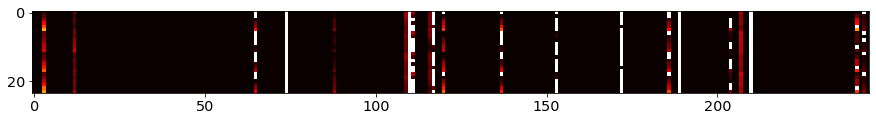

In [53]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,245)), cmap = "hot", vmin=0,vmax=1.0 );

In [54]:
u = pd.DataFrame(outSyn[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.071988,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016717,0.0,-1.000000,0.0
1,0.0,0.0,0.0,0.121510,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.147785,0.0,0.052025,0.0
2,0.0,0.0,0.0,0.215967,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.325941,0.0,0.059065,0.0
3,0.0,0.0,0.0,0.369405,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.367801,0.0,0.080268,0.0
4,0.0,0.0,0.0,0.471611,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.106738,0.0
5,0.0,0.0,0.0,0.621437,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.595992,0.0,0.136404,0.0


In [55]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.630290,0.629271,0.688235,0.332625,0.572247,0.651327,0.709770,0.276510,0.461589,0.442091,...,0.811426,0.836935,0.348147,0.348147,0.425058,0.390865,0.572641,0.605758,0.520441,0.460282
1,0.679429,0.598782,0.679060,0.312948,0.501809,0.694769,0.736314,-1.000000,0.562616,0.502785,...,0.803799,0.773869,0.430436,0.430436,0.520618,0.377990,0.629725,0.627226,0.603480,-1.000000
2,0.679668,0.569034,0.660106,0.321653,0.508297,0.685786,0.704436,-1.000000,0.527585,0.458724,...,0.829671,0.841796,0.414461,0.414461,0.429398,0.384251,0.617261,0.631014,0.578434,0.455383
3,0.622666,0.631905,0.664430,0.362718,0.481386,0.650971,0.754691,0.182870,0.517533,0.484508,...,0.737947,0.772426,0.345331,0.345331,0.495079,0.376468,0.682103,0.500355,0.577239,0.456085
4,0.765695,0.592536,0.670325,0.447501,0.469679,0.588251,0.734281,-1.000000,0.501568,0.414366,...,0.784941,0.754746,0.363333,0.363333,0.494566,0.547184,0.614375,0.613839,0.533392,0.447694
5,0.909198,0.555930,0.600608,0.684593,0.566607,0.666201,0.678537,0.514692,0.496297,0.434962,...,0.761315,0.768105,0.408423,0.408423,0.488222,0.609201,0.674039,0.732528,0.536272,0.407899


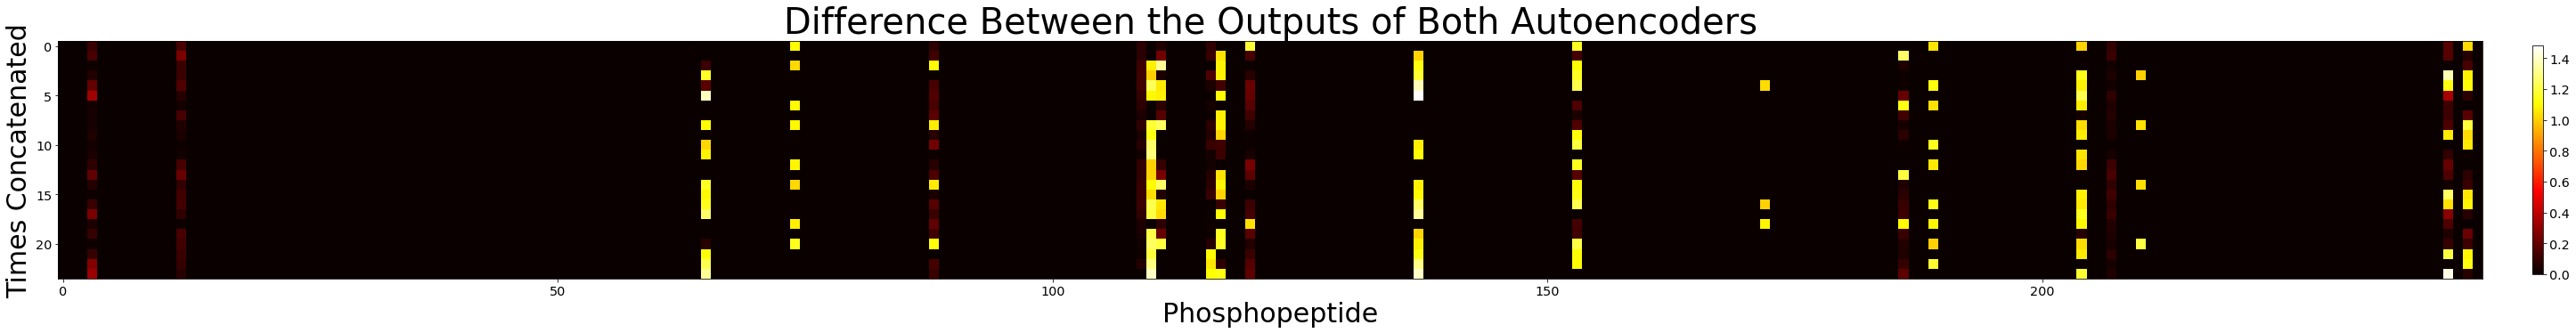

In [56]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

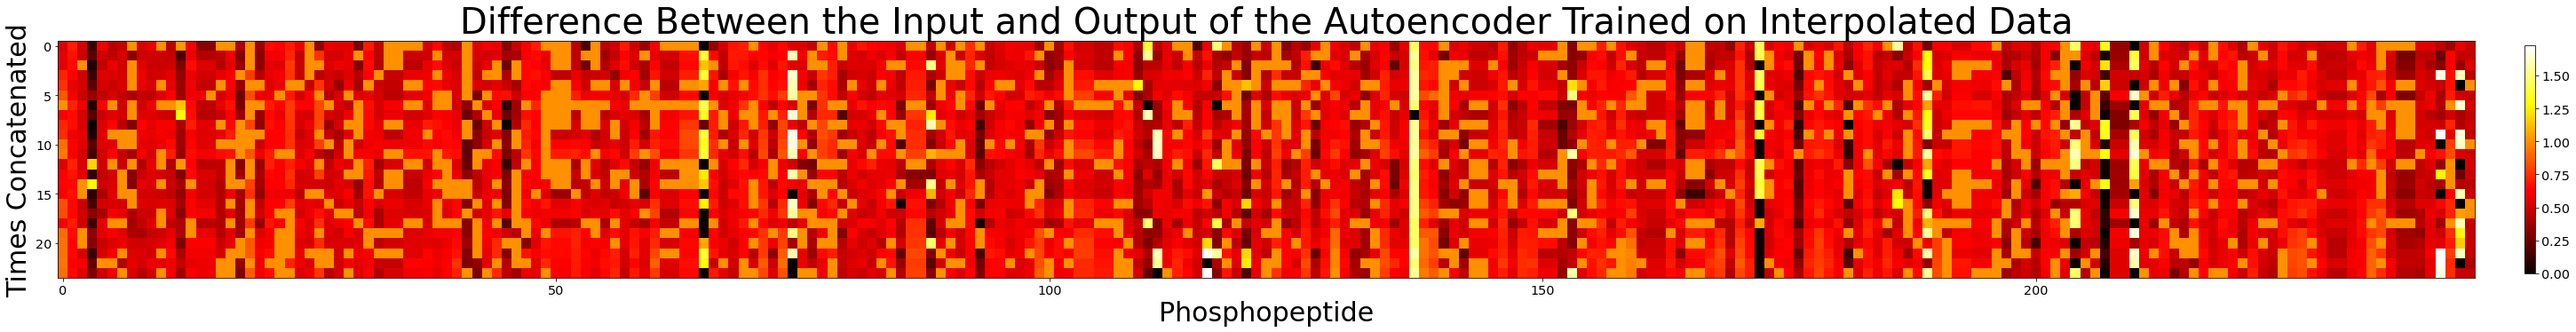

In [57]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,245)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02)
#plt.savefig("InterDiffImage.png")

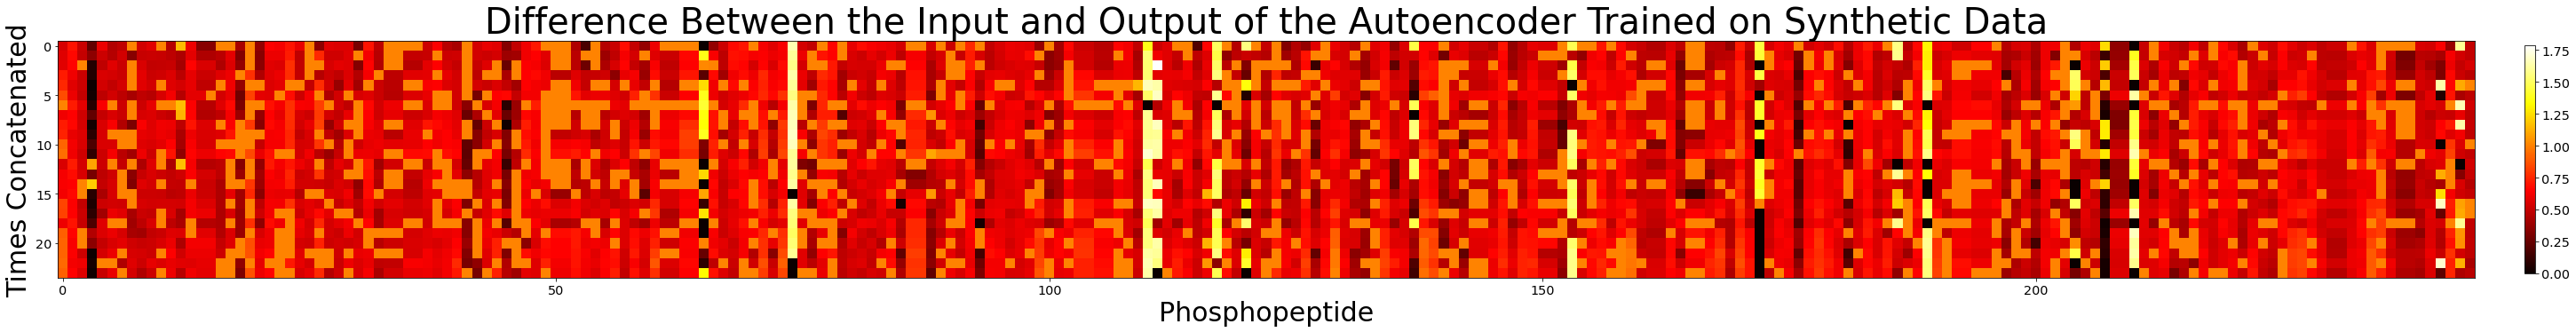

In [58]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

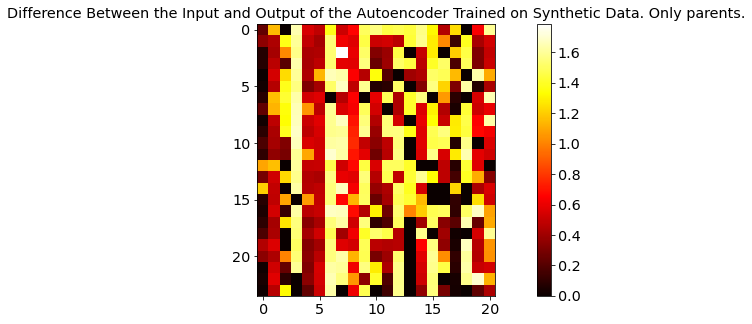

In [59]:
parent_idx = parentIndex.numpy()
#print(parent_idx)
oSyn = (np.reshape((outSyn), (24,245)).T)[parent_idx]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,245)).T)[parent_idx]
exp1_col = exp1_col.T

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot')
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [60]:
pd.DataFrame(oSyn).head(24)



,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.071988,0.148145,-1.000000,-1.0,0.008787,0.208128,-1.0,0.227940,0.132762,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.009184,0.239019,-1.0,0.016717,-1.000000
1,0.121510,0.066208,-1.000000,-1.0,0.033283,0.220358,-1.0,0.091067,0.157806,-1.000000,...,0.009191,0.000145,-1.000000,-1.000000,-1.0,0.013363,0.195995,-1.0,0.147785,0.052025
2,0.215967,0.118386,0.016143,-1.0,0.094677,0.187944,-1.0,-1.000000,0.148332,-1.000000,...,0.126730,-1.000000,-1.000000,0.082633,-1.0,-1.000000,0.199957,-1.0,0.325941,0.059065
3,0.369405,0.105809,0.160588,-1.0,0.095235,0.149574,-1.0,0.067730,0.159559,-1.000000,...,0.179689,-1.000000,-1.000000,0.190729,-1.0,-1.000000,0.211830,-1.0,0.367801,0.080268
4,0.471611,0.059921,0.237255,-1.0,0.104025,0.140468,-1.0,-1.000000,0.124898,0.097094,...,0.371921,-1.000000,0.028341,0.234127,-1.0,-1.000000,0.148439,-1.0,-1.000000,0.106738
5,0.621437,0.138766,0.379186,-1.0,0.169412,0.129390,-1.0,-1.000000,0.188221,-1.000000,...,0.481773,-1.000000,-1.000000,0.384211,-1.0,0.220746,0.174426,-1.0,0.595992,0.136404
6,0.136015,0.162588,-1.000000,-1.0,0.033696,0.142467,-1.0,0.246733,0.159768,-1.000000,...,-1.000000,0.035786,-1.000000,-1.000000,-1.0,0.066541,0.293209,-1.0,0.082843,-1.000000
7,0.150989,0.133167,-1.000000,-1.0,0.053317,0.165460,-1.0,0.097024,0.153017,-1.000000,...,-1.000000,0.058569,-1.000000,0.051632,-1.0,0.052806,0.269161,-1.0,0.091317,0.002576
8,0.192621,0.217931,-1.000000,-1.0,0.067797,0.139838,-1.0,-1.000000,0.104124,-1.000000,...,-1.000000,0.000174,-1.000000,0.091309,-1.0,0.030699,0.280813,-1.0,0.113305,-1.000000
9,0.252315,0.218621,-1.000000,-1.0,0.064531,0.132817,-1.0,-1.000000,0.066766,-1.000000,...,-1.000000,-1.000000,-1.000000,0.151425,-1.0,-1.000000,0.288029,-1.0,0.062388,0.028892


In [61]:
pd.DataFrame(exp1_col).head(24)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.311232,-1.000000,-1.000000,0.645008,0.554178,0.690925,0.372292,0.747749,0.794170,0.495021,...,0.455733,0.472685,0.439632,0.565228,0.317936,0.461916,-1.000000,-1.000000,0.654674,0.595213
1,0.476887,0.500798,0.372761,0.601316,0.522340,0.637735,0.535247,0.707668,0.727453,0.455223,...,0.541840,0.473143,0.425360,0.582488,0.284989,-1.000000,0.331113,0.386311,0.570334,0.587421
2,0.287767,0.537002,-1.000000,0.574648,0.523913,0.632452,0.534896,0.786278,0.743514,0.512682,...,0.514102,0.454378,-1.000000,0.581471,0.285557,-1.000000,-1.000000,0.455556,0.643895,0.558828
3,0.440943,0.578982,0.374815,0.635557,0.516269,0.629227,0.533493,0.653258,0.734303,0.552866,...,0.571450,0.508228,0.451286,0.664863,0.399603,0.511530,0.391555,0.491323,0.679073,0.593245
4,0.478201,0.598115,-1.000000,0.597923,0.538137,-1.000000,0.654905,0.629435,0.768833,0.556352,...,0.571788,-1.000000,0.426957,0.674205,0.511240,0.481536,-1.000000,-1.000000,0.627382,-1.000000
5,0.647987,0.592460,-1.000000,0.558520,0.478564,0.544962,0.509113,0.680942,0.671935,0.590083,...,0.569570,0.511285,-1.000000,0.706922,0.562933,-1.000000,0.484528,0.622751,0.667441,0.564833
6,0.218619,-1.000000,0.417378,0.628405,0.564403,0.711581,-1.000000,0.702340,0.808966,-1.000000,...,0.479980,0.475295,0.408973,0.555106,-1.000000,-1.000000,0.208531,-1.000000,0.630546,0.648886
7,0.383528,-1.000000,0.349100,0.655232,-1.000000,0.645061,0.590947,0.654156,0.782149,0.489829,...,-1.000000,0.492713,0.406376,0.615306,0.299354,0.503437,0.313722,0.427484,0.611733,0.597254
8,0.213567,0.697178,0.338363,0.662920,0.580581,0.713232,0.589343,0.673497,0.808274,0.542478,...,0.542131,0.532364,-1.000000,0.689703,0.336281,0.533574,-1.000000,0.463282,0.766182,0.630140
9,0.340220,0.644924,0.387990,0.686608,0.539759,0.681096,0.577242,0.597485,0.809513,0.586733,...,0.554080,0.557906,0.370342,0.723331,0.474744,0.549192,-1.000000,0.443230,0.727473,0.650377


In [62]:
pd.DataFrame(ddff).head(24)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.239244,1.148145,0.000000,-1.645008,-0.545391,-0.482797,-1.372292,-0.519809,-0.661408,-1.495021,...,-1.455733,-1.472685,-1.439632,-1.565228,-1.317936,-0.452732,1.239019,0.000000,-0.637957,-1.595213
1,-0.355377,-0.434590,-1.372761,-1.601316,-0.489057,-0.417377,-1.535247,-0.616601,-0.569647,-1.455223,...,-0.532649,-0.472998,-1.425360,-1.582488,-1.284989,1.013363,-0.135118,-1.386311,-0.422549,-0.535395
2,-0.071800,-0.418616,1.016143,-1.574648,-0.429236,-0.444507,-1.534896,-1.786278,-0.595182,-1.512682,...,-0.387373,-1.454378,0.000000,-0.498838,-1.285557,0.000000,1.199957,-1.455556,-0.317954,-0.499763
3,-0.071538,-0.473173,-0.214226,-1.635557,-0.421034,-0.479653,-1.533493,-0.585529,-0.574744,-1.552866,...,-0.391762,-1.508228,-1.451286,-0.474134,-1.399603,-1.511530,-0.179725,-1.491323,-0.311272,-0.512977
4,-0.006591,-0.538194,1.237255,-1.597923,-0.434112,1.140468,-1.654905,-1.629435,-0.643935,-0.459257,...,-0.199867,0.000000,-0.398616,-0.440078,-1.511240,-1.481536,1.148439,0.000000,-1.627382,1.106738
5,-0.026550,-0.453694,1.379186,-1.558520,-0.309152,-0.415572,-1.509113,-1.680942,-0.483714,-1.590083,...,-0.087797,-1.511285,0.000000,-0.322711,-1.562933,1.220746,-0.310103,-1.622751,-0.071448,-0.428429
6,-0.082604,1.162588,-1.417378,-1.628405,-0.530707,-0.569114,0.000000,-0.455607,-0.649197,0.000000,...,-1.479980,-0.439509,-1.408973,-1.555106,0.000000,1.066541,0.084678,0.000000,-0.547703,-1.648886
7,-0.232539,1.133167,-1.349100,-1.655232,1.053317,-0.479601,-1.590947,-0.557131,-0.629132,-1.489829,...,0.000000,-0.434144,-1.406376,-0.563673,-1.299354,-0.450631,-0.044561,-1.427484,-0.520416,-0.594678
8,-0.020945,-0.479247,-1.338363,-1.662920,-0.512784,-0.573394,-1.589343,-1.673497,-0.704150,-1.542478,...,-1.542131,-0.532190,0.000000,-0.598394,-1.336281,-0.502875,1.280813,-1.463282,-0.652877,-1.630140
9,-0.087905,-0.426303,-1.387990,-1.686608,-0.475228,-0.548280,-1.577242,-1.597485,-0.742746,-1.586733,...,-1.554080,-1.557906,-1.370342,-0.571906,-1.474744,-1.549192,1.288029,-1.443230,-0.665085,-0.621485


In [63]:
# np.save("interpolated_.npy", inter) #the interpolated dataset
# np.save("synthetic_.npy", genes_intensities_normalized[1:]) # the synthetic dataset
# np.save("synOut.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1

# Super parent with the synthetic dataset 
because the synthetic dataset performed the best

In [64]:
class EncoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(EncoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.OGrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DecoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.OGrgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        v = tf.zeros_like(X)
        u = tf.ones_like(X)
        u = tf.math.scalar_mul(-1.0, u)
        
        return tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelSuperParent(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [65]:
def modelSuperParentSequential(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    m = tf.keras.Sequential()
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

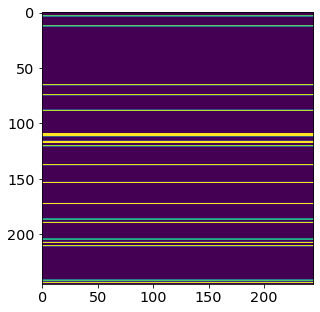

In [66]:
plt.imshow(superParent)

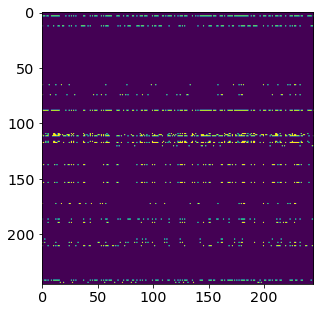

In [67]:
plt.imshow(regulator_gene_matrix)

In [68]:
looseParent = modelSuperParent(superParent, regulator_gene_matrix, 245, 6, 245, 21)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
looseParent.fit(syntheticDataTrain, syntheticDataTrain, epochs=240, verbose = 0)

In [69]:
ignore_noParent_MSE(k := looseParent.predict(testCandidate), testCandidate)

1/1 [==============================] - 0s 101ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=1.281754612902074>

In [70]:
u = np.reshape(k, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,0.060549,0.0
1,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.134525,0.0,0.071477,0.0
2,0.0,0.0,0.0,0.190897,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.285537,0.0,0.080107,0.0
3,0.0,0.0,0.0,0.343239,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.430176,0.0,0.102313,0.0
4,0.0,0.0,0.0,0.493547,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.574117,0.0,0.097955,0.0


In [71]:
u = np.reshape(testCandidate, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.630290,0.629271,0.688235,0.332625,0.572247,0.651327,0.709770,0.27651,0.461589,0.442091,...,0.811426,0.836935,0.348147,0.348147,0.425058,0.390865,0.572641,0.605758,0.520441,0.460282
1,0.679429,0.598782,0.679060,0.312948,0.501809,0.694769,0.736314,-1.00000,0.562616,0.502785,...,0.803799,0.773869,0.430436,0.430436,0.520618,0.377990,0.629725,0.627226,0.603480,-1.000000
2,0.679668,0.569034,0.660106,0.321653,0.508297,0.685786,0.704436,-1.00000,0.527585,0.458724,...,0.829671,0.841796,0.414461,0.414461,0.429398,0.384251,0.617261,0.631014,0.578434,0.455383
3,0.622666,0.631905,0.664430,0.362718,0.481386,0.650971,0.754691,0.18287,0.517533,0.484508,...,0.737947,0.772426,0.345331,0.345331,0.495079,0.376468,0.682103,0.500355,0.577239,0.456085
4,0.765695,0.592536,0.670325,0.447501,0.469679,0.588251,0.734281,-1.00000,0.501568,0.414366,...,0.784941,0.754746,0.363333,0.363333,0.494566,0.547184,0.614375,0.613839,0.533392,0.447694


In [72]:
# avgMSE = np.average(lossMatrix, axis = 0)
# plt.plot(np.arange(2,33,2), avgMSE);

# DenseNetAutoEncoder

In [73]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''
#TODO: fix call to map to -1?
class DenseEncoderLinear2(tf.keras.layers.Layer): #TODO: Fix the decoder to -1
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseEncoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.oldrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DenseDecoderLinear2(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseDecoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.oldrgm, dtype=dtype))

            return w_init

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose
        #return tf.matmul(inputs, self.w)
        

def denseencoder2(parent_child_biological_association, inp, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "tanh")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    #print(en_dense.shape, inp.shape)
    d = Concatenate()([en_dense, inp]) #dense layer
    en_dense = Dense(1024)(d) #added a layer
    
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def densedecoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(1024)(X)
    de_dense = Dense(256)(de_dense)#added a layer
    de_dense = Reshape((1, 256))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelDense2(rgm, oldrgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = DenseEncoderLinear2(rgm, oldrgm, 245, 245)(inp)
    #x = EncoderLinear2(x)
    enc = denseencoder2(x, inp, num_hidden_units)
    dec = densedecoder2(enc, num_protein_gene, time_steps)
    out = DenseDecoderLinear2(rgm, oldrgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [74]:
N = 2
hidden = np.arange(2,33, 6) #range(1,32)
lossMatrix = []
for i in tqdm(range(N)):
    
    losses = []
    for value in (hidden):
        dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, value)
        dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
        dense.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)

        test = dense(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(test, testCandidate)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 

100%|██████████| 2/2 [00:12<00:00,  6.06s/it]


Text(0, 0.5, 'MSE')

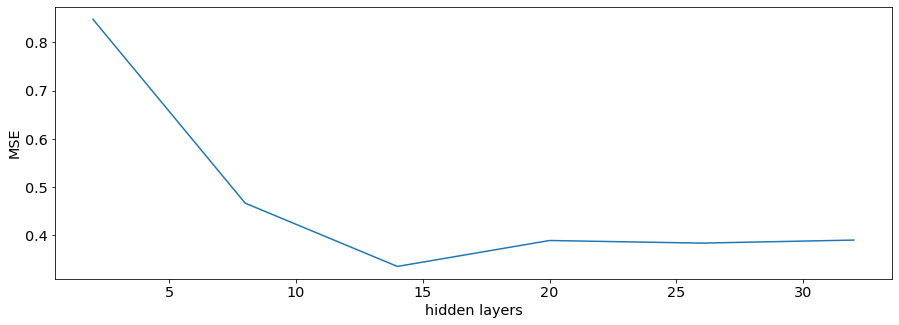

In [75]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(hidden, avgMSE);
plt.xlabel("hidden layers")
plt.ylabel("MSE")

# Lazy Kernels

In [76]:
ep = 60
hidden = [32,] #range(1,32)
lossMatrix = []
lazy_weights = []
dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, num_hidden_units=32)
dense.compile(optimizer='adam', loss=ignore_noParent_MSE)

for i in tqdm(range(ep)):
    dense.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=1,  verbose=0)
    lazy_weights.append(dense.get_weights())
    test = dense(testCandidate) #, verbose = 0)
    loss = ignore_noParent_MSE(test, testCandidate)
    lossMatrix.append(loss)
    
lossMatrix = np.array(lossMatrix)
lazy_weights = np.array(lazy_weights)

100%|██████████| 60/60 [00:04<00:00, 12.57it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [77]:
lossMatrix.shape

(60,)

In [78]:
lazy_weights.shape

(60, 12)

In [79]:
lazy_weights[0][0][parent_idx].shape

(21, 245)

In [80]:
parent_idx

array([  3,  12,  65,  74,  88, 109, 110, 111, 116, 117, 120, 137, 153,
       172, 186, 189, 204, 207, 210, 241, 243])

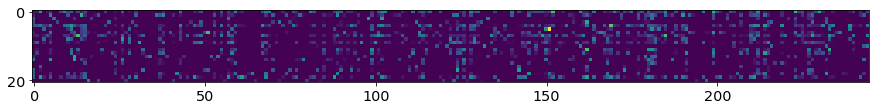

In [81]:
plt.imshow(np.abs(lazy_weights[0][0][parent_idx]))

In [82]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx=parent_idx):

    firstLayer = []
    for i in range(len(w)):
        firstLayer.append(w[i][0][parent_idx])

    fL = np.array(firstLayer)    
    d0 = np.square(fL[1] - fL[0])
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    return np.array(  kernelChange)

In [83]:
change = lazyKernelRegime(lazy_weights)

Text(0, 0.5, 'change in weight')

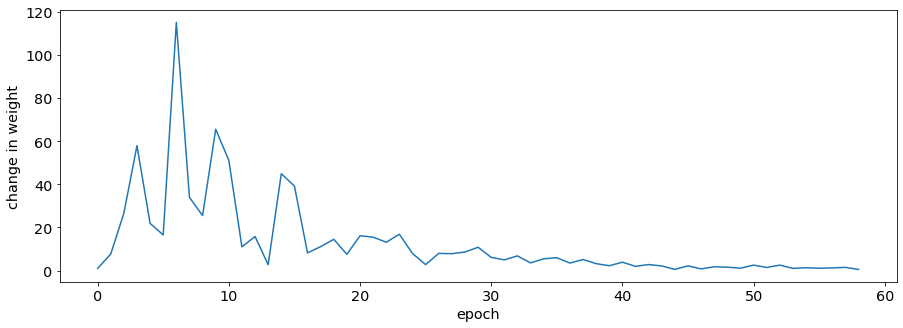

In [96]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

Text(0, 0.5, 'MSE')

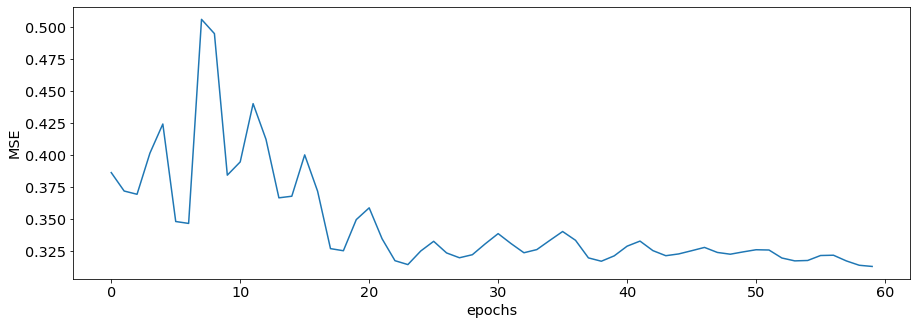

In [85]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [104]:
print(change.shape, lossMatrix.shape)

(21, 245, 59) (60,)


(58,)

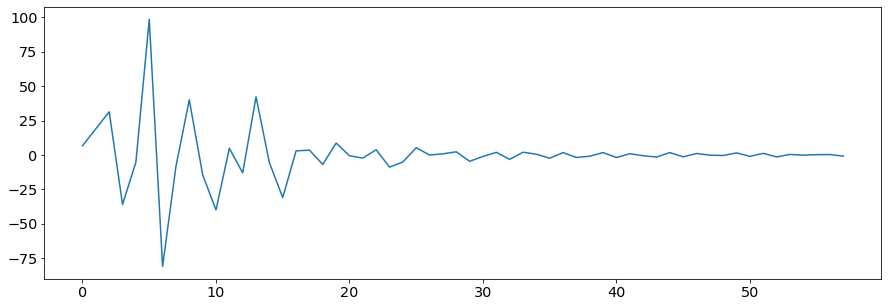

In [95]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [88]:
change[0][0].flatten()

array([1.0000000e+00, 6.2267208e+00, 8.4244858e+01, 2.3190759e+02,
       4.6938145e+01, 1.4571043e+01, 3.2468436e+02, 5.2167248e+01,
       1.9098307e+01, 2.3784262e+02, 1.4972844e+02, 9.0305321e+01,
       1.4454961e+01, 1.0191910e+01, 1.4444521e+02, 1.1422652e+02,
       4.4633780e+00, 7.0878799e+01, 1.0034342e+02, 2.4216372e+01,
       4.2676544e+01, 8.8577652e+00, 3.1776845e-02, 7.1697868e+01,
       4.3129757e+01, 1.0543992e+01, 3.4226681e+01, 1.0355385e+01,
       2.6150772e+01, 4.8526745e+00, 8.5592079e+00, 1.5769169e+01,
       5.3766422e+01, 1.8505602e+01, 1.4997946e+01, 3.8863201e+00,
       3.3604797e+01, 2.6563268e+00, 7.2169685e+00, 1.2690077e+01,
       2.8381071e+01, 7.7667198e+00, 8.0884752e+00, 1.2734420e+01,
       1.7506987e+01, 1.4849573e+01, 5.8457313e+00, 1.4414846e+01,
       4.9223903e-01, 1.8104948e+01, 6.3936701e+00, 1.4318429e+01,
       1.2278428e+01, 6.0279346e+00, 1.2717383e+01, 1.9357294e+00,
       6.8698397e+00, 7.1682763e+00, 1.3986886e+01], dtype=flo

58


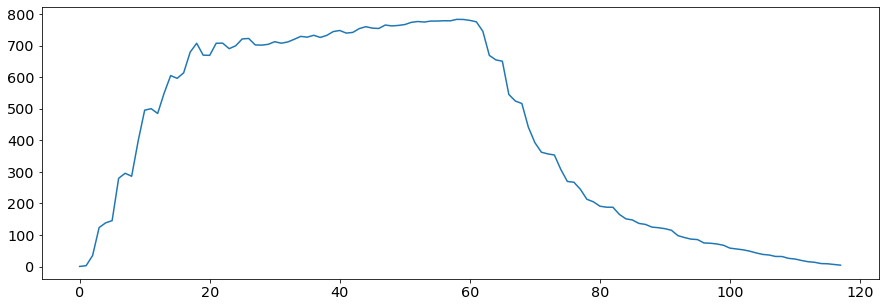

In [89]:
n = np.convolve(change[0][0].flatten(), lossMatrix[0: len(lossMatrix)].flatten(), mode='full' )
plt.plot(n)
print(np.argmax(n))

average stop:  22.824295432458698


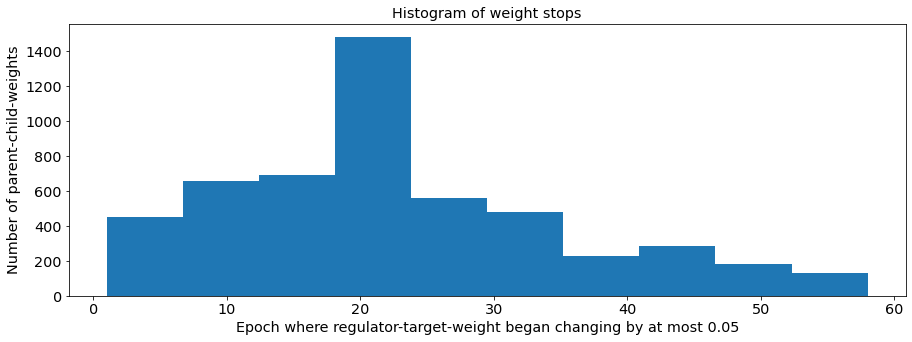

In [146]:
def compute_distrib(change, t = .05):
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)
    
    stop = np.array(stop).flatten()
    # print(stop.shape)
    var = np.std(stop)
    mean = np.average(stop)
    top_parents = np.argwhere(stop > mean + 2*var) #get the parents which take more than 2 stds to stop training
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (21, 245)))

    plt.hist(stop)
    plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t))
    plt.ylabel("Number of parent-child-weights")
    plt.title("Histogram of weight stops")
    print("average stop: ", mean)

    return np.array(top_parent_child)

top_pr = compute_distrib(change)


In [147]:
top_pr.shape

(281, 2, 1)

In [90]:
# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
    
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

[]
Stop value  0.05  is too high, trying stop =  0.1


Mean of empty slice.
invalid value encountered in double_scalars


()

In [2]:
beans = 0.5


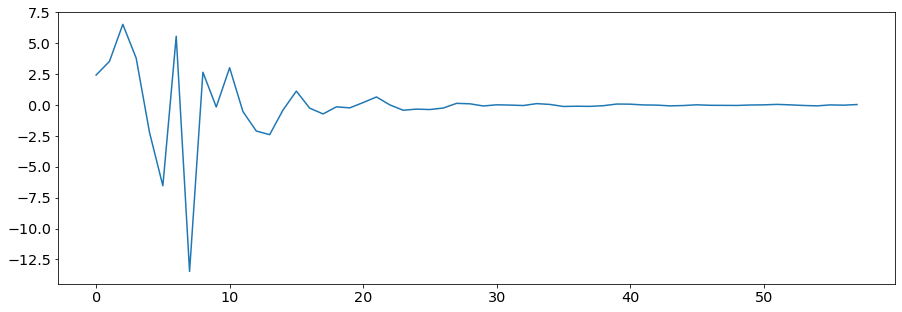

In [127]:
plt.plot(d[0])

In [126]:
o = np.argwhere(np.abs(d[0]) < .10)
np.min(o)

22

# Inference on Petal Len

In [ ]:
petal = pd.read_excel(data_path_petal)

In [ ]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

(4, 1)


array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [ ]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

(4, 1)


array([[ 0.33225729],
       [-0.11669058],
       [-0.62362506],
       [-0.59851746]])

In [ ]:
experiment1.shape
testCandidate.shape

(4, 6, 245)

In [ ]:
densePredictor = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(test, testCandidate)
print(loss)

tf.Tensor(0.29732401890859705, shape=(), dtype=float64)


In [ ]:
rgm = superParent
time_steps = 6
num_kinase_regulators = 245
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DenseEncoderLinear2(rgm, regulator_gene_matrix, 245, 245)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(1, activation = 'tanh', use_bias=False)(denseP.layers[-1].output)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [ ]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

(16, 6, 245)

In [ ]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

(16, 1)

In [ ]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=50, verbose = 1)

Epoch 1/50
1/1 [==============================] - 0s 361ms/step - loss: 0.0019
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 4/50
1/1 [==============================] - 0s 334ms/step - loss: 5.2796e-04
Epoch 5/50
1/1 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 9.2065e-04
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 6.9211e-04
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 6.3998e-04
Epoch 11/50
1/1 [==============================] - 0s 5ms/step - loss: 6.2288e-04
Epoch 12/50
1/1 [==============================] - 0s 5ms/step - loss: 6.1084e-04
Epoch 13/50
1/1 [============================

In [ ]:
testCandidate.shape

(4, 6, 245)

In [ ]:
denseP(experiment1)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[9.9160117e-01],
       [9.9910444e-01],
       [5.7509524e-04],
       [3.4071171e-01]], dtype=float32)>

In [ ]:
petal_train

array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [ ]:
print(denseP(testCandidate)) #model output

tf.Tensor(
[[0.30623925]
 [0.1851842 ]
 [0.2581004 ]
 [0.14238267]], shape=(4, 1), dtype=float32)


In [ ]:
petal_test #true label

array([[ 0.33225729],
       [-0.11669058],
       [-0.62362506],
       [-0.59851746]])

In [ ]:
petal_train

array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [ ]:
denseP.evaluate(testCandidate, petal_test)

1/1 [==============================] - 0s 97ms/step - loss: 1.3998


1.3997955322265625

# Junk

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)